In [1]:
# ✅ STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# ✅ STEP 2: Extract 'train.zip' from Google Drive
import zipfile
import os

zip_path = "/content/drive/MyDrive/Het Private/GDToT/train.zip"
extract_path = "/content/images"  # This will become your working folder

# Create folder and extract
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted files:", os.listdir(extract_path)[:5])


✅ Extracted files: ['img1596.jpg', 'img3951.jpg', 'img3233.jpg', 'img3068.jpg', 'img6948.jpg']


In [ ]:
# ✅ STEP 3: Now list and use images from the extracted folder
image_files = sorted([
    f for f in os.listdir(extract_path)
    if f.startswith("img") and f.lower().endswith(('.jpg', '.jpeg', '.png'))
], key=lambda x: int(x.replace("img", "").replace(".jpg", "")))

print(f"✅ Found {len(image_files)} images from img0.jpg to img{len(image_files)-1}.jpg")


In [16]:
# ✅ STEP 2: Crack Analysis + Life Estimation
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

def get_orientation_angle(cnt):
    rect = cv2.minAreaRect(cnt)
    angle = rect[-1]
    return angle + 90 if angle < -45 else angle

def orientation_label(angle):
    if -20 <= angle <= 20:
        return 'horizontal'
    elif 70 <= abs(angle) <= 110:
        return 'vertical'
    else:
        return 'diagonal'

image_files = sorted([
    f for f in os.listdir(extract_path)
    if f.startswith("img") and f.lower().endswith(('.jpg', '.jpeg', '.png'))
], key=lambda x: int(x.replace("img", "").replace(".jpg", "")))

data = []

for fname in tqdm(image_files):
    path = os.path.join(extract_path, fname)
    img = cv2.imread(path)
    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    crack_widths, crack_lengths, angles = [], [], []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h < 150: continue
        crack_widths.append(w)
        crack_lengths.append(h)
        angles.append(get_orientation_angle(cnt))

    avg_width = np.mean(crack_widths) if crack_widths else 0
    avg_length = np.mean(crack_lengths) if crack_lengths else 0
    angle = np.mean(angles) if angles else 0
    orientation = orientation_label(angle) if angles else "none"
    score = np.sum(np.array(crack_widths) * np.array(crack_lengths)) if crack_widths else 0

    # ✅ Custom life estimation
    if score < 1000:
        remaining_life = round(random.uniform(8, 10), 2)
    elif score < 3000:
        remaining_life = round(random.uniform(5, 7), 2)
    else:
        remaining_life = round(random.uniform(3, 4), 2)

    # ✅ Condition classification
    if remaining_life < 4:
        condition = "critical"
    elif remaining_life < 7:
        condition = "moderate"
    else:
        condition = "good"

    data.append({
        "image_name": fname,
        "crack_width_mm": round(avg_width * 0.264, 2),
        "crack_length_cm": round(avg_length * 0.0264, 2),
        "crack_orientation": orientation,
        "damage_score": round(score, 2),
        "condition_class": condition,
        "remaining_life_years": remaining_life
    })

df = pd.DataFrame(data)
df.head()


100%|██████████| 6950/6950 [14:44<00:00,  7.86it/s]


,image_name,crack_width_mm,crack_length_cm,crack_orientation,damage_score,condition_class,remaining_life_years
0,img0.jpg,15.06,1.69,diagonal,3015254,critical,3.12
1,img1.jpg,15.29,1.88,diagonal,1116942,critical,3.90
2,img2.jpg,13.97,1.41,diagonal,1790807,critical,3.35
3,img3.jpg,13.60,0.82,diagonal,1124428,critical,3.38
4,img4.jpg,19.02,3.02,diagonal,2021057,critical,3.69


In [15]:
# ✅ STEP 4: Save & download your generated CSV
csv_path = "/content/generated_bridge_data.csv"
df.to_csv(csv_path, index=False)

from google.colab import files
files.download(csv_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# ✅ STEP 4: Preprocess and Train Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define target
target = "remaining_life_years"

# Drop missing targets
df = df.dropna(subset=[target])

# One-hot encode categoricals
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if "image_name" in categorical_cols:
    categorical_cols.remove("image_name")

df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Define X and y
X = df_encoded.drop(columns=["image_name", target])
y = df_encoded[target]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ Train regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"✅ MAE: {mae:.2f}")
print(f"✅ MSE: {mse:.2f}")


✅ MAE: 0.25
✅ MSE: 0.09


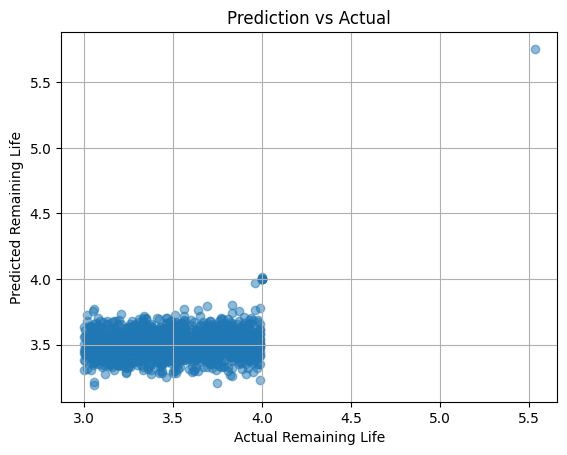

In [18]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Prediction vs Actual")
plt.grid(True)
plt.show()


In [19]:
print("Target in training features:", "remaining_life_years" in X.columns if hasattr(X, 'columns') else "Use df_encoded.columns")


Target in training features: False


In [20]:
print("Test set size:", len(y_test))


Test set size: 1390
